# TensorFlow 2.0

In [1]:
import os
from glob import glob
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt

%load_ext tensorboard
%matplotlib inline

## Hyperparameter Tunning

In [2]:
num_epochs = 5
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [3]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [4]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='sparse_categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

# Data Preprocess

In [5]:
train_paths = glob('dataset/cifar/train/*.png')[:100]
test_paths = glob('dataset/cifar/test/*.png')[:100]

In [6]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

In [7]:
train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [8]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot)  # 이번에는 onehot이 아닌 label 번호로

In [9]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.  # rescale
    
    label = get_label(path)
    return image, label

In [10]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [13]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

## Training

In [14]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs
)

Epoch 1/5
3/3 [==============================] - 1s 388ms/step - loss: 2.5053 - accuracy: 0.1029 - val_loss: 2.3177 - val_accuracy: 0.0938
Epoch 2/5
3/3 [==============================] - 1s 287ms/step - loss: 2.2567 - accuracy: 0.1912 - val_loss: 2.3174 - val_accuracy: 0.0729
Epoch 3/5
3/3 [==============================] - 1s 334ms/step - loss: 2.3062 - accuracy: 0.1146 - val_loss: 2.3241 - val_accuracy: 0.0729
Epoch 4/5
3/3 [==============================] - 1s 316ms/step - loss: 2.2321 - accuracy: 0.1471 - val_loss: 2.3243 - val_accuracy: 0.0729
Epoch 5/5
3/3 [==============================] - 1s 340ms/step - loss: 2.2539 - accuracy: 0.0882 - val_loss: 2.3436 - val_accuracy: 0.0729


# Predict

### 이미지를 Load 직접 load해서 넣는 방법

In [15]:
path = test_paths[0] # 예제 이미지
path

'dataset/cifar/test\\0_cat.png'

In [16]:
# image 불러오는 방법
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile, dtype=tf.float32)
image.shape

TensorShape([32, 32, 3])

In [17]:
# model predict할 때 batch size가 있어야 돼. 단일 이미지로는 predict 불가
# 왜냐면 4차원으로 넣어서 학습을 돌렸기때문에 predict도 4차원으로 맞춰줘야 돼
image = image[tf.newaxis, ...]

In [18]:
image.shape

TensorShape([1, 32, 32, 3])

In [20]:
pred = model.predict(image)

In [21]:
pred.shape # 이미지 1개 넣은 상태
# (1, 10) -> 이미지 1개에 대한 pred 10개

(1, 10)

In [22]:
pred

array([[0.09366836, 0.08083295, 0.11359921, 0.09158107, 0.12679616,
        0.06811095, 0.11320259, 0.09504919, 0.13555591, 0.08160356]],
      dtype=float32)

In [23]:
np.argmax(pred) # 정답을 8로 예측

8

### generator에서 데이터를 가져오는 방법
- path를 따로 불러오는 방법 말고도 generator를 넣어서 불러오는 방법도 있음

In [24]:
test_image, test_label = next(iter(test_dataset)) # 하나만 가져옴(batch 묶음 1개)

In [25]:
# generator를 이용하여 데이터를 가져오면 앞에서처럼 차원 수 하나 더 늘려줄 작업 필요x
test_image.shape

TensorShape([32, 32, 32, 3])

In [26]:
# predict는 image만!
pred = model.predict(test_image)

In [27]:
pred.shape # batch size만큼의 예측값

(32, 10)

In [28]:
pred[0]

array([0.09366836, 0.08083296, 0.11359921, 0.09158107, 0.12679616,
       0.06811094, 0.1132026 , 0.09504919, 0.13555591, 0.08160356],
      dtype=float32)

In [30]:
np.argmax(pred[0])

8

### generator에 넣는 방법

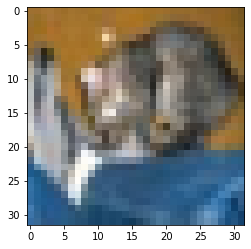

In [33]:
for image, label in test_dataset.take(1): # 1개의 batch만 가져옴
    plt.imshow(image[0])
    plt.show()

In [31]:
pred = model.predict_generator(test_dataset.take(1)) # 1개의 batch만 가져옴

In [32]:
pred.shape

(32, 10)

In [34]:
pred = model.predict_generator(test_dataset.take(2))
pred.shape

(64, 10)

In [36]:
image, label = next(iter(test_dataset))
image.shape

TensorShape([32, 32, 32, 3])

In [38]:
# evaluate은 image와 label 같이 넣는다!
evals = model.evaluate(image, label) 

32/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 2ms/sample - loss: 2.3514 -

In [39]:
evals

[2.3514249324798584, 0.125]